# Modeling
"Small" subsets Data from 
https://nijianmo.github.io/amazon/index.html (May 1996 - Oct 2018)

Justifying recommendations using distantly-labeled reviews and fined-grained aspects
Jianmo Ni, Jiacheng Li, Julian McAuley
Empirical Methods in Natural Language Processing (EMNLP), 2019

In [56]:
# Imports
import pandas as pd
import numpy as np
import os
import yaml
from utils.text import *

# NLP imports
#conda install spacy
import spacy
#!python -m spacy download en_core_web_sm
nlp = spacy.load('en_core_web_sm')
nlp.Defaults.stop_words |= {'one','unit', 'part', 'item', 'thing', 'review', 'stuff'}
#pip install aspect_based_sentiment_analysis
import aspect_based_sentiment_analysis as absa
#pip install textblob 
from textblob import TextBlob

# String manipulation
import re
#conda install bs4
from bs4 import BeautifulSoup
#pip install contractions
import contractions

# Data visualisation
import plotly.graph_objects as go
import matplotlib.pyplot as plt
#plt.style.use('ggplot')

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

config = yaml.safe_load(open('config.yml'))

# Output folder
in_dir = config['in_dir']
out_dir = config['out_dir']

# Create the output directory
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

In [57]:
product = 'SemEval'
test_df = xml_to_dataframe(os.path.join(in_dir, 'raw\EN_REST_SB1_TEST.xml.gold'), format='jsonl', output_file = 'test_data', in_dir = in_dir)
test_df = test_df.rename(columns={'prompt':'text', 'id': 'review_id'})
# Limiting size of text due to memory overload
test_df = break_row_by_size(test_df)
test_df

,id,text,completion
0,en_BlueRibbonSushi_478218171,Yum! Serves really good sushi. Not the biggest...,NULL; positive\nsushi; positive\nportions; ne...
1,en_BlueRibbonSushi_478218345,No Comparison – I can't say enough about this ...,NULL; positive\nplace; positive\nsushi; posit...
2,en_SchoonerOrLater_477965690,Snotty Attitude – We were treated very rudely ...,NULL; negative\nowner; negative END
3,en_SchoonerOrLater_477965849,Good food! – We love breakfast food. This is a...,food; positive\nmeal; positive\nNULL; positiv...
4,en_PagodaRestaurant_478006817,Overrated – I was highly disappointed in the f...,NULL; negative\nfood; negative\nlemon chicken...
...,...,...,...
89,en_Ray'sBoathouse_477775918,Much more than just a great view! – I am excee...,view; positive\nNULL; positive\nRay's Boathou...
89,en_Ray'sBoathouse_477775918,"of two was feeling particularly ambitious, and...",view; positive\nNULL; positive\nRay's Boathou...
89,en_Ray'sBoathouse_477775918,makes them unique (not to mention tasty). My f...,view; positive\nNULL; positive\nRay's Boathou...
89,en_Ray'sBoathouse_477775918,preteen who pretended to gag every time seafoo...,view; positive\nNULL; positive\nRay's Boathou...


## Aspect Extraction

### Rule based

In [58]:
def clean_text(text, stop_words = nlp.Defaults.stop_words, nlp = nlp, TextBlob = TextBlob, contractions = contractions):
    '''
    Return text with the modifications:
    Normalization (lowercase), Removal of unwanted characters and stopwords and lemmatization
    ''' 
    # Tabs
    #text = re.sub(r"[\n][\t]*|[\t]", " ", text) 
    # HTML tags removal
    #text = BeautifulSoup(text, 'html.parser').get_text()
    # Normalization (lowercase)
    text = text.lower()
    # Removing mentions (@person) and Hashtags #topic, 
    #text = re.sub(r"(@|#\ z0-9]+)|([^0-9A-Za-z \t])|^rt", "", text)
    # Links: http://
    #text = re.sub(r"https?:\/\/.*[\r\n]*", "", text, flags=re.MULTILINE) 
    # Contractions
    text = contractions.fix(text)
    # Removal of unwanted characters
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', '', text)
    # Numbers
    text = re.sub(r"[0-9]", "",text)
    # too long words: Incomprehensibilities is longest word “in common usage" or single letters
    text = re.sub(r"\b\w{25,90}\b|\b\w{1}\b", "",text)
    
    # Spelling correction
    text = str(TextBlob(text).correct())

    # Lemmatization
    lemmatized = []
     
    doc = nlp(text)
    for token in doc:
        lemmatized.append(token.lemma_)
    
    # Removing Stopwords
    if stop_words:    
        text = " ".join([word for word in lemmatized if word not in (stop_words)])
    text = re.sub(r'\s+',' ',text)
        
    return text.strip()

In [59]:
def get_absa(text, nlp=nlp):
    '''
    Aspect based Sentiment Analysis
    Input:  text as a string
            Spacy's nlp
    Output: For each noun get the list of Adjectives and their adverbs

    '''
    doc = nlp(text)
    aspects = []
    for sentence in doc.sents:
        description = ''
        aspect = ''
        for token in sentence:
            if token.dep_ == 'nsubj' and token.pos_ == 'NOUN':
                aspect = token.text
            if token.pos_ == 'ADJ':
                prepend = ''
                for child in token.children:
                    if child.pos_ != 'ADV':
                        continue
                    prepend += child.text + ' '
                description = prepend + token.text
        if (aspect != '' or description != ''):
            aspects.append({'aspect': aspect,'description': description})
    return aspects

In [60]:
#12min
# Text Cleaning
test_df['text_clean'] = test_df['text'].apply(lambda text: clean_text(text))

In [61]:
# Aspect Based Sentiment Analysis
test_df['absa_rule'] = test_df['text_clean'].apply(lambda text: get_absa(text))
test_df.head()

,id,text,completion,text_clean,absa_rule
0,en_BlueRibbonSushi_478218171,Yum! Serves really good sushi. Not the biggest...,NULL; positive\nsushi; positive\nportions; ne...,sum serve good big portion adequate green tea ...,"[{'aspect': 'rule', 'description': 'green'}]"
1,en_BlueRibbonSushi_478218345,No Comparison – I can't say enough about this ...,NULL; positive\nplace; positive\nsushi; posit...,comparison – place great service entire staff ...,"[{'aspect': 'comparison', 'description': 'extr..."
2,en_SchoonerOrLater_477965690,Snotty Attitude – We were treated very rudely ...,NULL; negative\nowner; negative END,knotty attitude – treat rudely time breakfast ...,"[{'aspect': 'attitude', 'description': 'rudely'}]"
3,en_SchoonerOrLater_477965849,Good food! – We love breakfast food. This is a...,food; positive\nmeal; positive\nNULL; positiv...,good food – love breakfast food great place de...,"[{'aspect': 'staff', 'description': 'great'}]"
4,en_PagodaRestaurant_478006817,Overrated – I was highly disappointed in the f...,NULL; negative\nfood; negative\nlemon chicken...,operate – highly disappointed food pagoda lemo...,"[{'aspect': '', 'description': 'nice'}]"


In [76]:
# Dataframe for each aspect
def show_aspects_graph(test_df = test_df, n = 15, out_dir = out_dir, product = product):
  """
  n: int of how many aspects are shown
  out_dir: directory of output for the aspects and descriptions
  """
  absa_df = pd.DataFrame()
  for i, row in enumerate(test_df['absa_rule']):
    absa_df_new = pd.DataFrame.from_records(row)
    absa_df_new['index'] = i
    
    absa_df = pd.concat([absa_df, absa_df_new], ignore_index=True)

  # Aspects's description per rule based method
  aspects_rule_based_df = absa_df.groupby(['aspect'])['description'].apply(lambda x: ', '.join(x))
  # Save
  aspects_rule_based_df.to_csv(os.path.join(out_dir, product+'_aspects_rule_based_df.csv'), sep=';', index=False)

  data = absa_df['aspect'].value_counts()[:n]
  # Create a horizontal bar plot
  fig = go.Figure(data=go.Bar(
      x=data.values,
      y=data.index,
      orientation='h',
      text = data.values
  ))

  # Set the layout
  fig.update_layout(
      title=f'Top {n} aspects',
      xaxis_title='Amount of reviews containing the aspect',
      yaxis_title='Aspects',
      yaxis=dict(autorange='reversed')
  )

  return fig

def formatting_for_absa(test_df = test_df):
  """
  """
  # List of aspects: list comprehension is faster than vectorisation 
  #https://stackoverflow.com/questions/54028199/are-for-loops-in-pandas-really-bad-when-should-i-care/54028200#54028200
  test_df['aspect'] = test_df['absa_rule'].apply(lambda x: [i['aspect'] for i in x if len(i['aspect'])>1 ])
  # Remove repeated aspects
  test_df['aspect'] = test_df['aspect'].apply(lambda x: list(dict.fromkeys(x)))
  # Filling in when aspect is not found
  #test_df['aspect'] = test_df['aspect'].apply(lambda x: x['product'] if len(x)==0 else x)
  # Removing when aspect is not found
  test_df = test_df[test_df['aspect'].str.len() > 0].reset_index(drop=True)
  # Limiting size of text due to memory overload
  #product_df['text'] = product_df['text'].apply(lambda text: text[:525])
  return test_df 

In [78]:
fig = show_aspects_graph()
fig.show()

test_df = formatting_for_absa()

## Sentiment Analysis

In [53]:
# From https://rafalrolczynski.com/2021/03/07/aspect-based-sentiment-analysis/
import aspect_based_sentiment_analysis as absa
from transformers import BertTokenizer

#from transformers import TFAutoModel
#model = TFAutoModel.from_pretrained("absa/classifier-rest-0.2")

# model_name = "absa/classifier-rest-0.2"
# model = absa.BertABSClassifier.from_pretrained(model_name)
# tokenizer = BertTokenizer.from_pretrained(model_name)
# professor = absa.Professor(...)
# text_splitter = absa.sentencizer()  # The English CNN model from SpaCy.
# nlp_absa = absa.Pipeline(model, tokenizer, text_splitter) #, professor

nlp_absa = absa.load()


Some layers from the model checkpoint at absa/classifier-rest-0.2 were not used when initializing BertABSClassifier: ['dropout_379']
- This IS expected if you are initializing BertABSClassifier from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertABSClassifier from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of BertABSClassifier were not initialized from the model checkpoint at absa/classifier-rest-0.2 and are newly initialized: ['dropout_113']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [79]:
# 80min
test_df['absa'] = test_df.apply(lambda x: nlp_absa(text=x['text'], aspects=x['aspect']), axis=1)

# Saving
try:
    test_df.drop(columns='absa').to_parquet(os.path.join(out_dir, product+'_absa_df.parquet'))
except:
    print('Saved as pickle and csv')
    test_df.to_pickle(os.path.join(out_dir, 'product_df.pickle'))
    test_df.to_csv(os.path.join(out_dir, 'product_df.csv'))
    test_df.drop(columns='absa').to_parquet(os.path.join(out_dir, product+'_absa_df.parquet'))

test_df.head()

,id,text,completion,text_clean,absa_rule,aspect,absa
0,en_BlueRibbonSushi_478218171,Yum! Serves really good sushi. Not the biggest...,NULL; positive\nsushi; positive\nportions; ne...,sum serve good big portion adequate green tea ...,"[{'aspect': 'rule', 'description': 'green'}]",[rule],"CompletedTask(text=""Yum! Serves really good su..."
1,en_BlueRibbonSushi_478218345,No Comparison – I can't say enough about this ...,NULL; positive\nplace; positive\nsushi; posit...,comparison – place great service entire staff ...,"[{'aspect': 'comparison', 'description': 'extr...",[comparison],"CompletedTask(text=""No Comparison – I can't sa..."
2,en_SchoonerOrLater_477965690,Snotty Attitude – We were treated very rudely ...,NULL; negative\nowner; negative END,knotty attitude – treat rudely time breakfast ...,"[{'aspect': 'attitude', 'description': 'rudely'}]",[attitude],CompletedTask(text='Snotty Attitude – We were ...
3,en_SchoonerOrLater_477965849,Good food! – We love breakfast food. This is a...,food; positive\nmeal; positive\nNULL; positiv...,good food – love breakfast food great place de...,"[{'aspect': 'staff', 'description': 'great'}]",[staff],CompletedTask(text='Good food! – We love break...
4,en_ParkChaletGardenRestaurant_477778282,Worst Service I Ever Had – A group of 5 of us ...,Service; positive\nservice; negative\nwaiter;...,bad service – group sunday branch sit outside ...,"[{'aspect': 'food', 'description': 'apologetic'}]",[food],CompletedTask(text='Worst Service I Ever Had –...


In [132]:
# Expanding per aspect
def expand_absa(test_df = test_df):
  """
  """
  result_df = pd.DataFrame()

  for index, row in test_df.iterrows():
    for example in row['absa'].examples:
      new_row = {
      'review_id': row['review_id'],
      #'asin': row['asin'],
      'text': row['text'],
      #'overall': row['overall'],
      'aspect': example.aspect.strip().title(),
      'sentiment':  str(example.sentiment).split(".")[1].strip().title(),
      'positive': example.scores[0],
      'negative': example.scores[1],
      'neutral': example.scores[2],
      }
      new_row = pd.DataFrame.from_dict(new_row, orient='index').T
      result_df = pd.concat([result_df, new_row], axis=0, ignore_index=True)

  result_df.to_parquet(os.path.join(out_dir, product+'_result_df.parquet'))
  return result_df

result_df = expand_absa()
result_df.head()

,review_id,text,aspect,sentiment,positive,negative,neutral
0,en_BlueRibbonSushi_478218171,Yum! Serves really good sushi. Not the biggest...,Rule,Positive,0.103454,0.376839,0.519708
1,en_BlueRibbonSushi_478218345,No Comparison – I can't say enough about this ...,Comparison,Positive,0.001361,0.000857,0.997782
2,en_SchoonerOrLater_477965690,Snotty Attitude – We were treated very rudely ...,Attitude,Negative,0.002322,0.895459,0.102219
3,en_SchoonerOrLater_477965849,Good food! – We love breakfast food. This is a...,Staff,Positive,0.000632,0.000963,0.998404
4,en_ParkChaletGardenRestaurant_477778282,Worst Service I Ever Had – A group of 5 of us ...,Food,Neutral,0.894267,0.104207,0.001526


In [99]:
# Evaluation
y_test_df = pd.read_parquet(os.path.join(in_dir, 'test_data.parquet'))
y_test_df = from_ai_to_df(y_test_df, column = "completion")
y_test_df = y_test_df.rename(columns={'prompt':'text', 'id': 'review_id', 'OTE': 'aspect', 'Entity':'sentiment'})
eval_df = y_test_df.merge(result_df[['review_id', 'text', 'aspect', 'sentiment']], left_on=['review_id','text'], right_on=['review_id','text'], suffixes=('_true', '_pred'), how='outer')
eval_df.to_parquet(os.path.join(out_dir, product+'_eval.parquet'))
eval_df
# OTE task failed.

,review_id,text,aspect_true,sentiment_true,aspect_pred,sentiment_pred
0,En Blueribbonsushi 478218171,Yum! Serves Really Good Sushi. Not The Biggest...,Null,Positive,NaN,NaN
1,En Blueribbonsushi 478218171,Yum! Serves Really Good Sushi. Not The Biggest...,Sushi,Positive,NaN,NaN
2,En Blueribbonsushi 478218171,Yum! Serves Really Good Sushi. Not The Biggest...,Portions,Neutral,NaN,NaN
3,En Blueribbonsushi 478218171,Yum! Serves Really Good Sushi. Not The Biggest...,Green Tea Creme Brulee,Positive,NaN,NaN
4,En Blueribbonsushi 478218345,No Comparison – I Can'T Say Enough About This ...,Null,Positive,NaN,NaN
...,...,...,...,...,...,...
783,en_SnoozeanAMEatery_480171723,meal all together. I rejected it because in th...,NaN,NaN,Peep,Negative
784,en_Ray'sBoathouse_477775918,Much more than just a great view! – I am excee...,NaN,NaN,Ray,Positive
785,en_Ray'sBoathouse_477775918,"of two was feeling particularly ambitious, and...",NaN,NaN,Compliment,Positive
786,en_Ray'sBoathouse_477775918,makes them unique (not to mention tasty). My f...,NaN,NaN,Dinner,Neutral


In [131]:
# Trying just sentiment analysis
y_test_df = pd.read_parquet(os.path.join(in_dir, 'test_data.parquet'))
y_test_df = from_ai_to_df(y_test_df, column = "completion")
y_test_df = y_test_df.rename(columns={'prompt':'text', 'id': 'review_id', 'OTE': 'aspect', 'Entity': 'sentiment'})
# Without an aspect in this framework it is not possible to retrieve the sentiment
y_test_df = y_test_df[y_test_df['aspect'] != 'Null']
aspects = y_test_df.groupby(['review_id','text'])['aspect'].agg(list).reset_index()
# ABSA
aspects['absa'] = aspects.apply(lambda x: nlp_absa(text=x['text'], aspects=x['aspect']), axis=1)
aspects

,review_id,text,aspect,absa
0,En Blueribbonsushi 478218171,Yum! Serves Really Good Sushi. Not The Biggest...,"[Sushi, Portions, Green Tea Creme Brulee]","CompletedTask(text=""Yum! Serves Really Good Su..."
1,En Blueribbonsushi 478218333,Great Meal – The Fish On The Omikase Platter W...,"[Meal, Fish On The Omikase Platter, Waitstaff,...","CompletedTask(text=""Great Meal – The Fish On T..."
2,En Blueribbonsushi 478218334,Whose Writing All The Great Reviews? Why Is It...,"[Place, Fish, Chef Special Dinner, Plate, Exot...",CompletedTask(text='Whose Writing All The Grea...
3,En Blueribbonsushi 478218337,"Good Sake, Good Food – I Honestly Don'T Know M...","[Sake, Food, Server, Lobster 3 Ways]","CompletedTask(text=""Good Sake, Good Food – I H..."
4,En Blueribbonsushi 478218339,Love It Every Time I Was Frankly Shocked When...,"[Place, Food, Waiting Staff, Wait]","CompletedTask(text=""Love It Every Time I Was ..."
...,...,...,...,...
85,En Snoozeanameatery 480171723,Insultingly Overpriced - Mediocre Service/Qual...,"[Service, Snooze, Menu, Snooze, Orange Juice, ...",CompletedTask(text='Insultingly Overpriced - M...
86,En Snoozeanameatery 480412257,Overpriced – We Dined At The Colorado Location...,"[Waiter, Feel, Bathroom Stall, Menu, Food, Food]",CompletedTask(text='Overpriced – We Dined At T...
87,En Stackrestaurant Bar 478538111,Late Night Dinning With Exeptional Food. – I D...,"[Food, Table, Service, Waiters, Filet Mignon, ...","CompletedTask(text=""Late Night Dinning With Ex..."
88,En Stackrestaurant Bar 478538239,"Good Food, Great Service, Average Prices (For ...","[Food, Service, Price Fixed Pre-Show Dinner, W...","CompletedTask(text=""Good Food, Great Service, ..."


,precision,recall,f1-score,support
Negative,0.740000,0.616667,0.672727,120.000000
Neutral,0.205882,0.175000,0.189189,40.000000
Positive,0.894212,0.943158,0.918033,475.000000
accuracy,0.833071,0.833071,0.833071,0.833071
macro avg,0.613365,0.578275,0.593316,635.000000
weighted avg,0.821710,0.833071,0.825764,635.000000


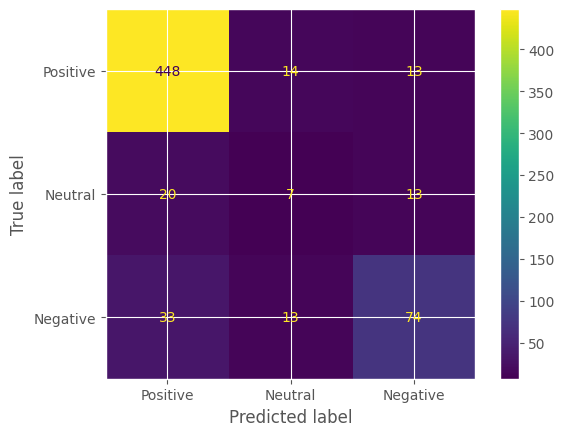

In [159]:
model_name = 'BERT_'+product
OTE_task = False

result_df = expand_absa(aspects)
eval_df = y_test_df.merge(result_df[['review_id', 'text', 'aspect', 'sentiment']], 
left_on=['review_id','text', 'aspect'], right_on=['review_id','text', 'aspect'], suffixes=('_true', '_pred'), how='outer')
if OTE_task:
  # To evaluate 
  y_test = np.where(eval_df['sentiment_true'].isna(), "###", eval_df['aspect'])
  y_pred = np.where(eval_df['sentiment_pred'].isna(), "###", eval_df['aspect'])
  cm = report(y_test, y_pred)
else:
  y_test = eval_df['sentiment_true']
  y_pred = eval_df['sentiment_pred']
  cm = report(y_test, y_pred, display_labels = y_test.unique())

## Amazon dataset

In [ ]:
product = 'laptop'
product_df = pd.read_parquet(os.path.join(in_dir, product+'_df.parquet'))

# Filtering product with 15 reviews
asins = product_df['asin'].value_counts()
asins = asins[(asins >= 15) & (asins <= 15)]
product_df = product_df[product_df['asin'].isin(asins.index)].reset_index()
product_df = product_df.rename(columns={'index':'review_id'})
# HTML tags removal
product_df['text']= product_df['text'].apply(lambda x: BeautifulSoup(x, 'html.parser').get_text())

In [ ]:
test_df = break_row(product_df)
# Text Cleaning
test_df['text_clean'] = test_df['text'].apply(lambda text: clean_text(text))
# Rule based ABSA
test_df['absa_rule'] = test_df['text_clean'].apply(lambda text: get_absa(text))
fig = show_aspects_graph()
fig.show()
# BERT
test_df = formatting_for_absa()

nlp_absa = absa.load()
test_df['absa'] = test_df.apply(lambda x: nlp_absa(text=x['text'], aspects=x['aspect']), axis=1)
result_df = expand_absa()
# Evaluation

from transformers import BertTokenizer
#!spacy download en_core_web_sm
import aspect_based_sentiment_analysis as absa
from aspect_based_sentiment_analysis import Professor

recognizer = absa.aux_models.BasicPatternRecognizer()
name = 'absa/classifier-rest-0.2'
model = absa.BertABSClassifier.from_pretrained(name)
tokenizer = BertTokenizer.from_pretrained(name)
professor = absa.Professor() 
text_splitter = absa.sentencizer()  # The English CNN model from SpaCy.
nlp_absa = absa.Pipeline(model, tokenizer, professor, text_splitter)

# Break down the pipeline `call` method.
task = nlp_absa.preprocess(text=text, aspects=aspects)
tokenized_examples = nlp_absa.tokenize(task.examples)
input_batch = nlp_absa.encode(tokenized_examples)
output_batch = nlp_absa.predict(input_batch)
predictions = nlp_absa.review(tokenized_examples, output_batch)
completed_task = nlp_absa.postprocess(task, predictions)
absa.summary(completed_task.examples[0])